# Programming for Data Analysis Project, 2019

The development of a simulated patient dataset in completion of the assessment as part of Module 52465, 'Programming for Data Analysis', Galway-Mayo Institue of Technology, 2019.


# 1. Aim

This notebook sets out the development of a dataset of simulated patients attending an Irish ED with uncomplicated sepsis. 

# 2. Rationale

Sepsis is a life-threatening condition that arises when a patient's immune system responds to an infection in a disproportionate manner [(Mayo Clinic 2019)](#refs). This causes the release of numerous hormones and related chemical responses in the body that can lead to tissue damage, which, if left untreated, can lead to organ failure and death [(Sepsis Alliance 2019)](#refs). 

Early recognition of uncomplicated sepsis (i.e. no organ dysfunction) in patients presenting to Emergency Departments is associated with improved patient outcomes [(Seymour et al. 2017)](#refs). A recent study showed that an active alert system reduced inpatient mortality and morbidity on a large scale [(Honeyford et al. 2019)](#refs). This system made use of real time patient information to detect sepsis and alert healthcare givers to provide prompt treatment, leading to lower odds of death (OR: 0.76; 95%CI: 0.70-0.84). A similar system in Irish Emergency Departments could prove valuable, particularly given the ongoing 'trolley crisis' [(Halpin & Thomas 2019)](#refs) and its association with increased patient mortality at 10 days [(Richardson 2006)](#refs). A simulated dataset would allow training of such an algorithm on large patient numbers.

# 3. Assumptions

1. In order for sepsis to be present, an infective source needs to be present. It will be assumed that if any of the patients within the dataset fulfill the criteria for sepsis, that they have a likely infective source.


2. The dataset will only make use of clinical parameters that can be measured at presentation; that is, laboratory parameters will not be included in the dataset. The 'general variables' presented in Appendix 7 of the National Clinical Effectiveness Committee's Sepsis Managament National Clinical Guideline No. 6 [(Ireland, National Clinical Effectiveness Committee 2014)](#refs) will be the only variables of interest included in the dataset. These are as follows:
    1. Temperature <36 or >38.3 degrees celsius
    2. Heart rate >90 beats per minute
    3. Respiratoty rate >20 breaths per minute
    4. Altered mental state, recorded as 'Yes' or 'No'
    5. Blood glucose level of >7.7 mmol/L in non-diabetic 
    
    
3. Patients with co-morbidities (e.g. diabetes, compromised immune system, etc) are at increased risk of developing sepsis [(Sepsis Alliance 2019)](#refs). For the sake of this dataset, it will be assumed that no patient has a co-morbidity or prior medical history that places them at increased risk of developing uncomplicated sepsis.


4. Only patients between 18 and 65 years of age will be included in the dataset. Children have different physiological parameters than adults, and thus different cut-offs for defining sepsis [(Mathias, Mira and Larson 2016)](#refs). Adults over the age of 65 are more likely to have multiple co-morbidities [(Barnett et al 2012)](#refs), and thus including this population in the dataset will not accurately reflect a 'real' population. 


5. Gender will not be part of the dataset. Although gender is associated with outcomes in patients with *developed* sepsis, there is insufficient evidence that gender is a risk factor for *developing* sepsis [(McNevin et al. 2016)](#refs).

# 4. Developing the dataset parameters

In [28]:
# Import necessary packages to create and plot dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import truncnorm

# Increase plot production image sizes and font sizes - Adapted from: https://stackoverflow.com/a/3900167
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 16})

The first step in developing a dataset of ED patients with uncomplicated sepsis is developing a population with 'normal' vital sign parameters. Once this dataset is created, patients are randomly selected from within this dataset and 'given' a diagnosis of sepsis with appropriate changes to their physiological parameters. The final dataset then contains a simulated population of ED patients, of which an appropriate random proportion will have uncomplicated sepsis based on vital sign changes as mentioned above. 

## 4.1. Creating the 'normal' ED population
### 4.1.1. Size
According to the Central Statistics Office (CSO) [(Central Statistics Office 2011)](#refs), 10% of the adult Irish population over 18 years of age attended an ED. Based on the 2016 census [(Central Statistics Office 2018)](#refs), the population of Ireland >18 years of age was estimated at 3,424,795. This equates to roughly 9,383 A&E visits across the country every day. However, the 10% CSO statistic includes repeat presentations; a report compiled by the HSE in 2006 [(Ireland, HSE 2006)](#refs) placed this figure closer to 3,300. For the interest of this database, we will work with a daily ED attendance number of 3,500. 

### 4.1.2. Age distribution
Presentations to ED are not evenly distributed across age categories, with a bimodal presentation at 18-24 years of age, and 70+ [(Central Statistics Office 2011)](#refs). A bimodal distribution of this type can be represented by two normal distributions [(Ho 2018)](#refs) centred around a mean of 18 and 70 respectively, with a standard deviation (SD) of 15 for each. This SD allows for ~95% of the sample from each distribution to arise between two SD from the mean. Although this does not make biological sense for the mean of 18 (2 SD of 15 years below 18 years will be equal to minus 12 years), it does ensure that there is overlap between the two distributions in the middle (between ~40 and ~48 years of age) as shown in the following plot: 


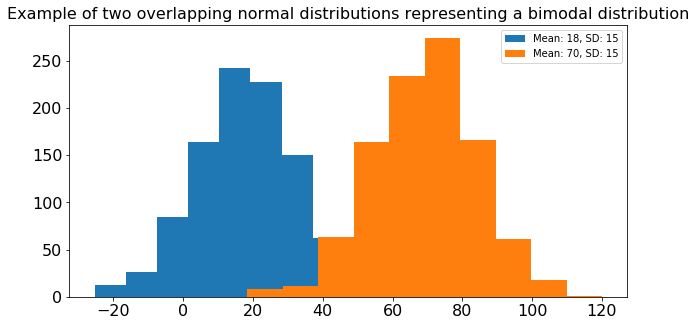

In [29]:
# Generate two normal distributions of 1,750 values, young and old, with mean of 18 and 70 respectively, 
# and standard deviation of 15
y = np.random.normal(18, 15, 1000)
o = np.random.normal(70, 15, 1000)

# Plot histograms of the two distributions on the same plot
plt.hist(y, label="Mean: 18, SD: 15")
plt.hist(o, label="Mean: 70, SD: 15")
# Add plot details
plt.title("Example of two overlapping normal distributions representing a bimodal distribution", fontsize=16)
plt.legend(fontsize=10)

Thus, two normal distributions provide a bimodal distribution that represents the desired distribution as it occurs in reality. As there is roughly an equal proportion of attendees in the 18-24 age bracket (13%) and the 70+ age bracket (11%) [(Central Statistics Office 2011)](#refs), an equal proportion from each distribution is sampled in this dataset.

### 4.1.3. Vital signs

#### Temperature, heart rate and respiratory rate
The normal values for these vital signs are as follows [(National Institutes of Health 2019)](#refs):
- temperature: 36.5 to 37.3 degrees Celsius
- heart rate: 60 to 100 beats per minute
- respiratory rate: 12 to 18 breaths per minute

For the purpose of this dataset, it is assumed that these values are normally distributed. Individual patient vital signs are thus calculated from within these ranges by selecting a random value from a normal distribution centred around the middle value (median) of the range, with a SD equal to the interquartile range (IQR) divided by 1.35 [(Researchgate 2014)](#refs). In this instance, the IQR is considered equal to the range between the lowest/highest value and the median. Thus, for example, the mean and SD for the normal sampling distribution of temperature is calculated as follows:
 - mean = median = (37.3 + 36.5)/2 = 36.9
 - SD = IQR/1.35 = (36.9 - 36.5)/1.35 = 0.3

#### Blood glucose level
Blood glucose level is dependent on time since last meal [(Diabetes.co.uk 2019)](#refs), and normal is considered any value within the following range:
- 4.0 (fasting) to 7.7mmol/L (post-prandial)

Calculation of values for this variable are performed in the same manner as the above continuous variables.  

#### Mental state
There are many ways of measuring mental status in the Emergency Department [(Xiao et al. 2012)](#refs). For that reason, no single scale is defined for this variable. Instead, this is a binary variable: mental status is either altered ('yes') or normal ('no'). This variable is initially set at 'no'.

### 4.1.4. Sepsis
The variable of sepsis is defined as either absent ('no') or present ('yes'). This variable is initially set as 'no' to reflect the initial non-septic population

## 4.2. Creating sepsis patients within the 'normal' ED population
### 4.2.1. Proportion with sepsis

According to a study conducted in one of the busiest EDs in Ireland [(McNevin et al. 2016)](#refs), roughly 4.24% of ED presentations fulfill the criteria for uncomplicated sepsis. This proportion is not evenly distributed across age brackets, with older patients more likely to have sepsis (median age 45 years without sepsis versus 65 years for those with sepsis). In order to accurately reflect this, 4% of the 'normal' population dataset between the ages of 50 and 65 will be randomly selected to have sepsis. A remaining 0.5% will be randomly selected from the remaining 'normal' population to reflect the possibility of sepsis arising at any age.

### 4.2.2. Vital signs of septic patients
In order for a patient to be diagnosed with uncomplicated sepsis, they need to have 2 or more abnormal vital signs. However, the probability of more than two abnormal vital signs decreases with each additional vital sign as follows [(McNevin et al. 2016)](#refs): 

Number | Probability 
--- | ---
 2 | 55% 
 3 | 36% 
 4 | 7% 
5 | 2% 

To accurately represent this decreasing probability, the number of vital signs to adjust is randomly selected from between 2 to 5 using the numpy `random.choice` module, with probability for the value decreasing in line with the probabilities in the table above. This value is then used to randomly select a corresponding number of vitals from the following list using the `random.choice` module again: temperature, heart rate, respiratory rate, blood glucose level, altered mental state. To ensure that the same vital sign is not drawn more than once, the list is updated at each extraction to remove the already selected vital sign.

#### Temperature
The median(IQR) temperature  of patients presenting to ED with sepsis is 36.7(36-38) degrees celsius [(McNevin et al. 2016)](#refs). In order to ensure that the vital will change in line with sepsis criteria (<36 or >38.3 degrees celsius), the upper and lower limit of range from which to randomly select values is calculated as follows:

- Lower limit = lower IQR - (median - lower IQR) = 36.0 - (36.7 - 36.0) = 36.0 - 0.7 = 35.3
- Upper limit = upper IQR + (upper IQR - median) = 38.0 + (38.0 - 36.7) = 38.0 + 1.3 = 39.3

A `random.binomial` distribution function is used to randomly select whether the temperature variable will be above 38.3 or below 36. The value in either range is then selected randomly using the `random.uniform` function to select a value from a uniform distribution.

#### Heart rate
The median(IQR) heart rate of patients presenting to ED with sepsis is 104(89-113) beats per minute [(McNevin et al. 2016)](#refs). Sepsis is defined as a heart rate of >90 beats per minute. As above, the upper range limit is calculated as follows:

- Upper limit = upper IQR + (upper IQR - median) = 113 + (113 - 104) = 113 + 9 = 122

Thus, values are randomly selected from a range of 91 to 122 using the `random.randint` function to represent septic values. 

#### Respiratory rate
The median(IQR) respiratory rate of patients presenting to ED with sepsis is 18(16-20) breaths per minute [(McNevin et al. 2016)](#refs). Sepsis is defined as a respiratory rate of >20 breaths per minute. As above, the upper range limit is calculated as follows:

- Upper limit = upper IQR + (upper IQR - median) = 20 + (20 - 18) = 20 + 2 = 22

Thus, values are randomly selected from a range of 21 to 22 using the `random.randint` function to represent septic values. 

#### Blood glucose level
The median(IQR) blood glucose level of patients presenting to ED with sepsis is 7.6(6.0-9.0) mmol/L [(McNevin et al. 2016)](#refs). Sepsis is defined as a blood gluose level > 7.7mmol/L. As above, the upper range limit is calculated as follows:

- Upper limit = upper IQR + (upper IQR - median) = 9.0 + (9.0 - 7.6) = 9.0 + 1.4 = 10.4

Thus, values are randomly selected from a range of 7.8 to 10.4 using the `random.uniform` function on a `numpy` array, to represent septic values from a uniform distribution. 

#### Mental state
The variable mental state is a binary outcome, initially set to 'no' (to indicate no altered mental state). If this variable is selected as one of the variables to be changed in the 'normal' population to represent sepsis, this variable is changed to 'yes', to represent altered mental state.

### 4.2.3. Sepsis
Patients selected from the 'normal' ED population whose vitals are changed to represent sepsis will automatically have this binary variable changed from 'no' to 'yes', to indicate that they have uncomplicated sepsis.

# 5. The final dataset
Once the values of the randomly selected patients have been changed as above, they are appended back onto the original dataframe. Duplicate indices are then removed from the dataframe, with the argument set to `keep=last`, so as to keep the last duplicate index added to the dataframe. This ensures that the original 'normal' patient is removed while the 'septic' patient remains. Finally, the dataframe is re-sorted into index order, maintaining the original count and order. 

# 6. Limitations

1. The dataset only contains patients between 18 and 65 years of age. In practice, most adult EDs in Ireland will accept patients over the age of 16 years, and there is no limit on patients over the age of 65 years. However, as already mentioned, these cutoffs were decided based on different physiological parameters in children, and increased co-morbidity in adults over 65 years of age.


2. The parameters for sepsis do not include all variables as laid out in the NCEC sepsis guidelines [(Ireland, National Clinical Effectiveness Committee 2014)](#refs). However, the missing variables all relate to laboratory investigations, which are time consuming. Given the proven benefit of initiating antibiotic therapy early in sepsis [(Seymour et al. 2017)](#refs), this dataset only focuses on those parameters that can be completed at triage for uncomplicated sepsis. 


3. There are gaps in the distribution of vital signs between septic and non-septic patients, as noted in the pairplot at the end of this notebook. This is because normal vital signs do not necessarily abut abnormal vital signs (e.g. normal temperature is 36.5 to 37.3, while septic parameters are <36.0 or >38.3). This can be changed by adjusting the limits for the normal range, without impacting on the rate of sepsis. However, for this dataset, the limits as specified in the literature have been applied. 

<a id='refs'></a>
# 7. References
* BARNETT, K., MERCER, S.W., NORBURY, M., WATT, G. WYKE, S., GUTHRIE, B., 2012. 'Epidemiology of multimorbidity and implications for health care, research, and medical education: a cross-sectional study'. *Lancet*. **380**, 37-43
* CENTRAL STATISTICS OFFICE, 2011. *Health Status and Health Service Utilisation. Quarterly National Household Survey: Quarter 3 2010*. Dublin: Central Statistics Office
* CENTRAL STATISTICS OFFICE, 2018. *Databases: Population 2011 to 2016 by Age Last Birthday, At Each Year of Age, Sex and Census Year*. [Online] Available at: https://statbank.cso.ie/px/pxeirestat/Statire/SelectVarVal/Define.asp?maintable=EY007&PLanguage=0 [Accessed 4 December 2019]
* DIABETES.CO.UK, 2019. *Living with Diabetes: Blood Sugar Level Ranges* [Online]. Available from: https://www.diabetes.co.uk/diabetes_care/blood-sugar-level-ranges.html [Accessed 2 December 2019]
* HALPIN, H. & THOMAS, C., 2019. 'Woman (70) 'left for 105 hours on trolley' in Limerick Hospital'. *thejournal.ie* [Online] Available at: https://www.thejournal.ie/woman-70-left-for-105-hours-on-trolley-in-limerick-hospital-4832123-Oct2019/ [Accessed 7 December 2019]
* HO, M., 2018. *Generating “Fake” Data for Proofs of Concept*, 19 September 2018. [Online]. Available from: https://medium.com/@michellemho/faking-data-87c063cf38a7 [Accessed 3 December 2019]
* HONEYFORD, K., COOKE, G.S., KINDERLERER, A., WILLIAMSON, E., GILCHRIST, M., HOLMES, A., THE SEPSIS BIG ROOM, GLAMPSON, B., MULLA, A., COSTELLOE, C., 2019. 'Evaluating a digital sepsis alert in a London multisite hospital network: a natural experiment using electronic health record data'. *Journal of the American Medical Informatics Association*. [Online] ocz186, DOI:10.1093/jamia/ocz186 [Accessed 2 December 2019] 
* IRELAND. HSE, 2006. *Health Service Executive Emergency Departments: Patient Profiles, Experiences and Perceptions*. Naas: Consumer Affairs Department
* IRELAND. National Clinical Effectiveness Committee, 2014. *Sepsis Management National Clinical Guideline No 6*. Dublin: Department of Health
* MATHIAS, B., MIRA, J., LARSON, S.D., 2016. 'Pediatric Sepsis'. *Current Opinion in Pediatrics*. **28**(3), 380-387
* MAYO CLINIC, 2019. *Patient Care and Health Information. Disease & Conditions: Sepsis* [Online] Available from: https://www.mayoclinic.org/diseases-conditions/sepsis/symptoms-causes/syc-20351214. [Accessed 5 December 2019]
* MCNEVIN, C., MCDOWELL, R., FITZPATRICK, F., GILLIGAN, P., WAKAI, A., 2016. 'What Proportion of Patients Meet the Criteria for Uncomplicated Sepsis in an Irish Emergency Department?'. *Irish Medical Journal*. **109**(7), 435
* NATIONAL INSTITUTES OF HEALTH, 2019. *Medical Encyclopedia: Vital signs* [Online] Available at: https://medlineplus.gov/ency/article/002341.htm [Accessed 2 December 2019]
* RESEARCHGATE, 2014. *Questions: Is there any way to get mean and SD from median and IQR (interquartile range)?* [Online] Available at: https://www.researchgate.net/post/Is_there_any_way_to_get_mean_and_SD_from_median_and_IQR_interquartile_range [Accessed 3 December 2019]
* RICHARDSON, D.B., 2006. 'Increase in patient mortality at 10 days associated with emergency department overcrowding'. *Medical Journal of Australia*. **185**(5), 213-216
* SEPSIS ALLIANCE, 2019. *What is sepsis* [Online] Available at: https://www.sepsis.org/sepsis-basics/what-is-sepsis/ [Accessed 5 December 2019]
* SEYMOUR C.W., GESTEN, F., PRESCOTT, H.C., FRIEDRICH, M.E., IWASHYNA, T.J., PHILLIPS, G.S., LEMESHOW, S., OSBORN, T., TERRY, K.M., LEVY, M.M., 2017. 'Time to Treatment and Mortality during Mandated Emergency Care for Sepsis'. *New England Journal of Medicine*. **376**(23), 2235-2244
* XIAO, H., WANG, Y., XU, T., ZHU, H., GUO, S., WANG, Z., YU, X., 2012. 'Evaluation and treatment of altered mental status patients in the emergency department: Life in the fast lane'. *World Journal of Emergency Medicine*. **3**(4), 270-277

# 8. Code

The code for development of the final dataframe follows. In addition to the code, visualisation of certain parameters are also shown, both as a means of assessing distribution, and as a means of ensuring content validity.

The following global variables are used in several sections of the code. By adjusting the values represented here, users can create new datasets without having to adjust individual values within the code.

In [3]:
# Create global variables
COUNTER = 0            #resets the counter for count loops in the code
POP = 3500             #size of dataset 
OLDER = int(POP*0.04)  #proportion of older population with sepsis
REST = int(POP*0.005)  #proportion of total population with sepsis

In [4]:
# Define functions

#-----------------------------------
# Normal vital sign value function
'''Create normal vital sign values from normal distribution.
    Takes 3 arguments of type integer or float: a = lower range limit
                                                b = upper range limit
                                                size = population size
    Returns a list of values from a normal distribution between a and b of size 'size' '''

def values(a, b, size): # a and b are range limits; size is population size
    # calculate mean
    mn = abs(round((a+b)/2, 2))
    #print(mn)
    
    # calculate standard deviation (SD)
    sd = abs(round((mn-a)/1.35, 2))
    #print(sd)
    
    # set counter
    count = COUNTER
    
    # create empty list
    ls = []
    
    # determine values
    while count < size:
        x = (np.random.normal(mn, sd))
        if x < a or x > b:
            continue
        else:
            ls.append(x)
            count += 1 
        
    # return list
    return ls
#=====================================

#-------------------------------------
# Sepsis vital sign value function
''' Creates septic values for patients.
    Takes 2 arguments:  a = row from Dataframe, type object
                        b = value, type integer
    Adjusts selected vital signs and returns dataframe object'''

def sepsis(a, b): # a is the df row; b is the number of variables to change
    vitals = np.array(['temp', 'pulse', 'resp_rate', 'sugar', 'alt_ment']) # Adapted from: https://docs.scipy.org/doc/numpy-1.13.0/user/basics.creation.html
    for i in range(b):
    # Randomly select variables to change
        vc = np.random.choice(vitals)
        vitals = vitals[vitals!=vc] # Adapted from: https://thispointer.com/delete-elements-from-a-numpy-array-by-value-or-conditions-in-python/
        # print(vc)
        # print(vitals)
        if vc == 'pulse':
            a.at[:, 'pulse'] = np.random.randint(91, 123) # Adapted from: https://www.edureka.co/community/43220/how-to-change-update-cell-value-in-python-pandas-dataframe
            # print(a)
        if vc == 'temp':
            # decide on random upper or lower limit using binomial distribution
            dec = np.random.binomial(1, 0.5)
            if dec == 1:
                a.at[:, 'temp'] = round(np.random.uniform(38.3, 39.4), 1)
            else:
                a.at[:, 'temp'] = round(np.random.uniform(35.3, 36.1), 1)
            # print(a)
        if vc == 'resp_rate':
            a.at[:, 'resp_rate'] = np.random.randint(21, 23)
            # print(a)
        if vc == 'sugar':
            a.at[:, 'sugar'] = round(np.random.uniform(7.8, 10.5), 1)
            # print(a)
        if vc == 'alt_ment':
            a.at[:, 'alt_ment'] = 'yes'
            # print(a)
    a.at[:, 'sepsis'] = 'yes'  
    #print(a)
#=====================================

In [5]:
# Create ages variable - thanks to fellow student Andrzej Kocielski for the tip

# Set variables for limits, mean and standard deviation for each distribution
ynglower, yngupper = 18, 48
oldlower, oldupper = 40, 66
yngmean = 18 #age range 18-24 used in CSO publication
oldmean = 70 #age range 70+ used in CSO publication
sigma = 15

# Create values for young distribution function
ynga = (ynglower - yngmean) / sigma
yngb = (yngupper - yngmean) / sigma

# Create values for old distribution function
olda = (oldlower - oldmean) / sigma
oldb = (oldupper - oldmean) / sigma

# Create young distribution
yng = np.int64(truncnorm.rvs(ynga, yngb, loc=yngmean, scale=sigma, size=int(POP/2)))

# Creat old distribution
old = np.int64(truncnorm.rvs(olda, oldb, loc=oldmean, scale=sigma, size=int(POP/2)))

# Concatenate both into single ndarray
ages = np.append(yng, old)

Text(0.5, 1.0, 'Distribution of ages')

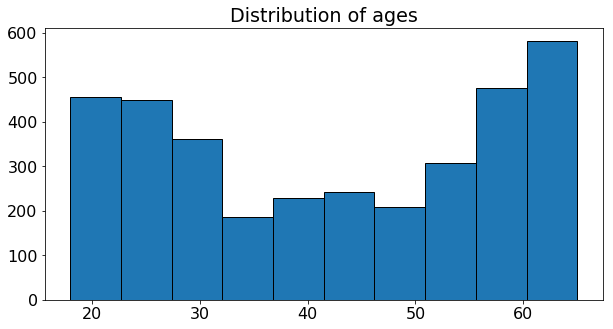

In [30]:
# Plot ages list to visualise bimodal distribution
plt.hist(ages, edgecolor='k')
plt.title("Distribution of ages")

In [7]:
# Create lists of normal vital signs
temp = values(36.5, 37.3, POP) #temperature
hr = values(60, 100, POP)      #heart rate
rr = values(12, 18, POP)       #respiratory rate
gluc = values(4.0, 7.7, POP)   #blood glucose level

Text(0, 0.5, 'Count')

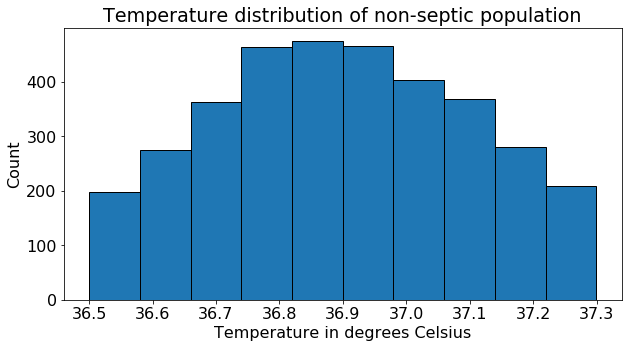

In [31]:
# Plot each variable in turn to confirm distribution visually

# Temperature
plt.hist(temp, edgecolor='k')
plt.title('Temperature distribution of non-septic population')
plt.xlabel('Temperature in degrees Celsius')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

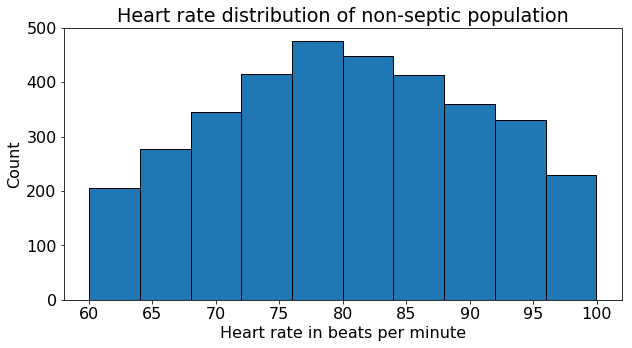

In [32]:
# Heart rate
plt.hist(hr, edgecolor='k')
plt.title('Heart rate distribution of non-septic population')
plt.xlabel('Heart rate in beats per minute')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

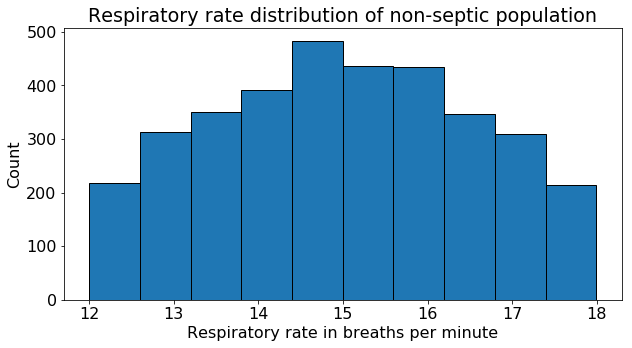

In [33]:
# Respiratory rate
plt.hist(rr, edgecolor='k')
plt.title('Respiratory rate distribution of non-septic population')
plt.xlabel('Respiratory rate in breaths per minute')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

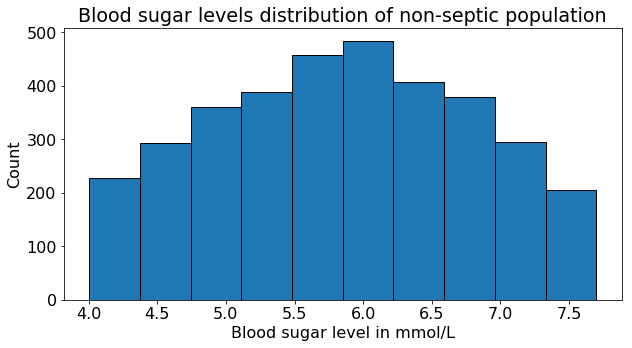

In [34]:
# Blood glucose level
plt.hist(gluc, edgecolor='k')
plt.title('Blood sugar levels distribution of non-septic population')
plt.xlabel('Blood sugar level in mmol/L')
plt.ylabel('Count')

In [12]:
# Create dataframe of 'normal' patient population from above value lists - Adapted from: https://stackoverflow.com/a/30522778
df = pd.DataFrame({'temp': temp, 'pulse': hr, 'resp_rate': rr, 'sugar': gluc})
df.insert(0, 'age', ages) #Adapted from: https://discuss.codecademy.com/t/can-we-add-a-new-column-at-a-specific-position-in-a-pandas-dataframe/355842

In [13]:
# Round appropriately to reflect sensical values (whole numbers, not all floats) - Adapted from: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.round.html
df = df.round({'temp': 1, 'pulse': 0, 'resp_rate': 0, 'sugar': 1})

In [14]:
# Convert pulse and respiratory rate float columns to integers to allow appropriate manipulation of values - Adapted from: https://stackoverflow.com/a/21291622
df.pulse = df.pulse.astype(int)
df.resp_rate = df.resp_rate.astype(int)

In [15]:
# Add in the mental status column with all values set to 'no' - Adapted from: https://www.interviewqs.com/ddi_code_snippets/add_new_col_df_default_value
df['alt_ment'] = 'no'

# Add in sepsis column with all values set to 'no'
df['sepsis'] = 'no'

In [16]:
# Confirm that values entered of correct type to allow appropriate manipulation
print(df.dtypes)

age            int64
temp         float64
pulse          int64
resp_rate      int64
sugar        float64
alt_ment      object
sepsis        object
dtype: object


In [17]:
# Confirm dataframe stored correctly by checking if head and tail align
df.head()

,age,temp,pulse,resp_rate,sugar,alt_ment,sepsis
0,41,37.2,83,16,4.7,no,no
1,20,36.6,87,16,5.9,no,no
2,42,37.2,77,17,5.9,no,no
3,29,37.2,82,14,6.2,no,no
4,26,37.2,84,16,6.6,no,no


In [18]:
df.tail()

,age,temp,pulse,resp_rate,sugar,alt_ment,sepsis
3495,60,36.9,76,16,6.9,no,no
3496,54,36.8,99,13,6.7,no,no
3497,51,36.9,83,15,5.6,no,no
3498,65,36.8,71,15,5.3,no,no
3499,54,36.9,71,15,4.7,no,no


In [19]:
# Evaluate the values in the 'normal' ED population
df.describe()

,age,temp,pulse,resp_rate,sugar
count,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000
mean,42.240286,36.898914,80.358571,14.998857,5.847486
std,15.639159,0.202764,10.200239,1.570665,0.943846
min,18.000000,36.500000,60.000000,12.000000,4.000000
25%,27.000000,36.700000,73.000000,14.000000,5.100000
50%,43.000000,36.900000,80.000000,15.000000,5.900000
75%,58.000000,37.100000,88.250000,16.000000,6.600000
max,65.000000,37.300000,100.000000,18.000000,7.700000


In [20]:
# Randomly select sample from older population and adjust vital signs to represent sepsis

# Reset counter
count = COUNTER

# Run through older proportion of sample 
while count < OLDER:
    # Choose observation randomly from population over 50 years of age
    x = df.loc[df.age >= 50].sample() # Adapted from: https://www.pybloggers.com/2018/11/how-to-use-pandas-sample-to-select-rows-and-columns/
    # print(x)
    if (x['sepsis'] == 'yes').bool(): # Adapted from: https://stackoverflow.com/a/36922103
        continue
    # Randomly determine number of vital signs to change (2, 3, 4, or 5) with reducing probability - Adapted from: https://stackoverflow.com/a/4266645
    num = np.random.choice(np.arange(2, 6), p=[0.55, 0.36, 0.07, 0.02])
    # print(num)
    # Adjust the corresponding number of vital signs using the sepsis function
    sepsis(x, num)
    df = df.append(x) # Append the altered observation to original dataframe - Adapted from: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html
    # print(x)
    count += 1 # Increment counter by one until required proportion altered
    # print(count) 

In [21]:
# Randomly select sample from the remaining population and adjust vital signs to represent sepsis

# Reset count
count = COUNTER

# Run through rest of sample
while count < REST: 
    # Choose observation randomly from remaining population
    x = df.sample() 
    # print(x)
    if (x['sepsis'] == 'yes').bool(): 
        continue
    # Randomly determine number of vital signs to change (2, 3, 4, or 5) with reducing probability 
    num = np.random.choice(np.arange(2, 6), p=[0.55, 0.36, 0.07, 0.02])
    # print(num)
    # Adjust the corresponding number of vital signs using the sepsis function
    sepsis(x, num)
    df = df.append(x) # Append the altered observation to original dataframe
    # print(x)
    count += 1 # Increment counter by one until required proportion altered
    # print(count) 

In [22]:
# Remove duplicate indices from appended dataframe, keeping the last index added (which will be the septic patient)
df = df.loc[~df.index.duplicated(keep='last')] # Adpated from: https://stackoverflow.com/a/34297689

In [23]:
# Confirm that observations have been changed by visualising the tail of the dataframe 
# (appended observations added to the end)
df.tail()

,age,temp,pulse,resp_rate,sugar,alt_ment,sepsis
2635,55,37.3,120,21,9.4,no,yes
2429,65,36.7,62,22,6.7,yes,yes
1968,62,36.8,100,18,9.1,yes,yes
640,37,35.8,95,22,6.2,no,yes
2764,57,37.0,104,16,9.6,no,yes


In [24]:
# Re-sort the dataframe into ascending order by index
df.sort_index() # http://www.datasciencemadesimple.com/sort-the-dataframe-in-python-pandas-by-index/

,age,temp,pulse,resp_rate,sugar,alt_ment,sepsis
0,41,37.2,83,16,4.7,no,no
1,20,36.6,87,16,5.9,no,no
2,42,37.2,77,17,5.9,no,no
3,29,37.2,82,14,6.2,no,no
4,26,37.2,84,16,6.6,no,no
5,28,37.3,77,13,4.5,no,no
6,19,36.8,86,13,6.6,no,no
7,19,36.8,71,15,4.0,no,no
8,33,37.0,80,15,7.0,no,no
9,34,36.5,96,14,6.5,no,no


In [25]:
# View septic population
df[df['sepsis'] == 'yes']

,age,temp,pulse,resp_rate,sugar,alt_ment,sepsis
2540,56,36.9,116,21,4.6,no,yes
2109,64,37.0,65,21,5.8,yes,yes
2765,61,35.3,76,21,5.1,no,yes
3157,56,35.6,69,22,8.3,no,yes
2495,60,38.7,106,16,5.5,yes,yes
2879,50,35.8,91,22,9.9,no,yes
2107,65,36.6,107,22,4.3,no,yes
1808,58,37.0,86,15,9.2,yes,yes
3298,61,36.9,110,21,5.2,yes,yes
2087,65,35.5,66,16,9.6,no,yes


In [26]:
# Confirm the final dataset proportion of septic patients equals 4.5% as intended
z = df['sepsis'].value_counts()
round(z.yes/z.no*100, 1)

4.3

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


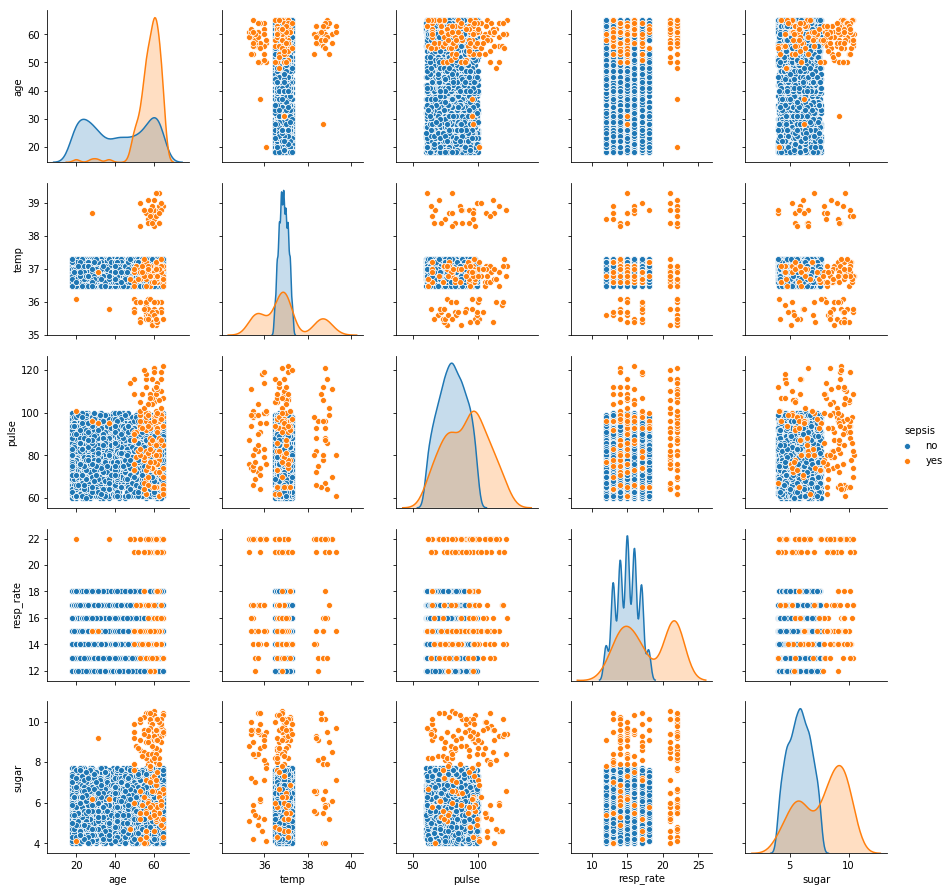

In [27]:
# Visualise distribution of septic patients within the dataset
sns.pairplot(df, hue='sepsis')